In [66]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import glob
 
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache
import pandas as pd
import h5py
import re
from sklearn.mixture import GaussianMixture as GMM

import unagi
from unagi import config
from unagi import hsc
from unagi.task import hsc_tricolor, hsc_cutout
import umap
from imageio import imwrite

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [3]:
cat_fn = '../data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_cosmos.csv'

In [4]:
cat = pd.read_csv(cat_fn)

In [5]:
for k in sorted(cat.keys()):
    print(k)

Unnamed: 0
Unnamed: 0.1
Unnamed: 0.1.1
Unnamed: 0.1.1.1
a_g
a_i
a_r
a_y
a_z
dec_x
dec_y
g_blendedness_abs_flux
g_blendedness_flag
g_cmodel_flag
g_cmodel_fracdev
g_cmodel_mag
g_cmodel_magsigma
g_extendedness_flag
g_extendedness_value
g_inputcount_value
g_localbackground_flux
g_pixelflags_bright_object
g_pixelflags_bright_objectcenter
g_pixelflags_clipped
g_pixelflags_clippedcenter
g_pixelflags_cr
g_pixelflags_crcenter
g_pixelflags_edge
g_pixelflags_inexact_psf
g_pixelflags_inexact_psfcenter
g_pixelflags_interpolated
g_pixelflags_interpolatedcenter
g_pixelflags_rejected
g_pixelflags_rejectedcenter
g_pixelflags_saturated
g_pixelflags_saturatedcenter
g_psfflux_flag
g_psfflux_mag
g_psfflux_magsigma
i_blendedness_abs_flux
i_blendedness_flag
i_cmodel_dev_ellipse_11
i_cmodel_dev_ellipse_12
i_cmodel_dev_ellipse_22
i_cmodel_ellipse_11
i_cmodel_ellipse_12
i_cmodel_ellipse_22
i_cmodel_ellipse_ellipticity
i_cmodel_ellipse_radius
i_cmodel_ellipse_theta
i_cmodel_exp_ellipse_11
i_cmodel_exp_ellipse_12

In [6]:
cat = cat.set_index('Unnamed: 0')

In [7]:
cat

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,object_id,ra_x,dec_x,tract_x,patch_x,parent_id_x,a_g,...,r_cmodel_exp_ellipse_12,r_cmodel_dev_ellipse_11,r_cmodel_dev_ellipse_22,r_cmodel_dev_ellipse_12,r_cmodel_ellipse_11,r_cmodel_ellipse_22,r_cmodel_ellipse_12,i_cmodel_ellipse_radius,i_cmodel_ellipse_ellipticity,i_cmodel_ellipse_theta
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
930469,930469,930469,959426,43153636661928257,149.419824,1.759877,9812,1,0,0.068090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.962126,0.631997,-72.408003
930472,930472,930472,959429,43153636661941675,149.501037,1.628040,9812,1,43153636661922149,0.061950,...,7.973921e-03,3.500360,17.354601,1.091601e-01,0.508333,2.047580,7.973921e-03,1.913607,0.611278,-88.493481
930473,930473,930473,959430,43153636661942071,149.495663,1.632822,9812,1,43153636661922436,0.061634,...,1.119458e-10,0.000007,0.000007,2.256304e-08,0.000012,0.000012,1.119458e-10,0.009278,0.186135,35.884203
930474,930474,930474,959431,43153636661944644,149.494814,1.675906,9812,1,43153636661924395,0.062425,...,-7.206630e-07,0.000080,0.000086,8.289192e-06,0.000175,0.000173,-7.206630e-07,0.009822,0.305118,4.776509
930475,930475,930475,959432,43153636661944760,149.486638,1.676278,9812,1,43153636661924492,0.062669,...,1.399018e-01,0.387397,0.371909,3.103442e-01,0.270391,0.258992,2.075485e-01,0.822187,0.796321,-44.008288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937776,937776,937776,966912,43159159989889369,149.507494,2.830884,9813,807,43159159989869051,0.061976,...,6.452020e-02,0.352902,0.776300,1.751370e-01,0.269721,0.572581,1.237647e-01,1.049147,0.435658,-75.946569
937777,937777,937777,966913,43159159989889446,149.583488,2.832980,9813,807,43159159989869115,0.060030,...,2.771537e-02,0.104280,0.164310,4.700084e-02,0.103667,0.163101,4.648047e-02,0.498539,0.521982,-62.829638
937778,937778,937778,966914,43159159989890737,149.538152,2.855478,9813,807,43159159989870227,0.060834,...,1.786133e-07,0.000056,0.000056,2.624067e-07,0.000056,0.000056,2.624067e-07,NaN,NaN,NaN


In [8]:
cat.loc[930469]

Unnamed: 0.1                               930469
Unnamed: 0.1.1                             930469
Unnamed: 0.1.1.1                           959426
object_id                       43153636661928257
ra_x                                       149.42
                                      ...        
r_cmodel_ellipse_22                           NaN
r_cmodel_ellipse_12                           NaN
i_cmodel_ellipse_radius                   24.9621
i_cmodel_ellipse_ellipticity             0.631997
i_cmodel_ellipse_theta                    -72.408
Name: 930469, Length: 180, dtype: object

In [9]:
#im_ix_fix = np.loadtxt('../data/tables/im_ix_fix.dat', dtype=int)
#def idx_to_loc(idx):
#    idx = int(idx)
#    loc = im_ix_fix[idx]
#    return loc

In [10]:
tag = 'gri_cosmos_fix'
imarr_fn = '../data/images_h5/images_{}.h5'.format(tag)
results_fn = '../results/results_{}.h5'.format(tag)

In [11]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'disc_scores', 'gen_scores', 'idxs', 'object_ids', 'reconstructed']>


In [12]:
print(imarr['idxs'])

<HDF5 dataset "idxs": shape (3452,), type "<f4">


In [13]:
scores = res['anomaly_scores']
idxs = res['idxs']
object_ids = res['object_ids']

In [14]:
print(res['idxs'].value)
print(imarr['idxs'].value)

#im_ix = np.argsort(res['idxs'])
def idx_to_loc(idx):
    idx = int(idx)
    loc = list(imarr['idxs']).index(idx)
    return loc

[930469. 930472. 930473. ... 937092. 937093. 937094.]
[930469. 930472. 930473. ... 937092. 937093. 937094.]


/Users/ksf/miniconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [15]:
idx2imloc = {}
for i in range(len(imarr['idxs'])):
    idx2imloc[imarr['idxs'][i]] = i
    
idx2resloc = {}
for i in range(len(res['idxs'])):
    idx2resloc[res['idxs'][i]] = i

In [16]:
print(idxs)
print(min(idxs), max(idxs))

<HDF5 dataset "idxs": shape (3452,), type "<f4">
930469.0 937781.0


In [18]:
print(idxs[0])
print(idx_to_loc(idxs[0]))
print(idx2imloc[idxs[0]])

930469.0
0
0


-0.19330281 33.600384


[]

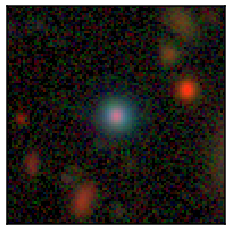

In [113]:
idxx = 934297
plt.figure(figsize=(4,4))
ax = plt.gca()
loc = idx2imloc[idxx]
im = imarr['images'][loc]
print(min(im.flatten()), max(im.flatten()))
ax.imshow(luptonize(imarr['images'][loc]))
#ax.set_title(idxx)
ax.set_xticks([])
ax.set_yticks([])

In [21]:
objx = cat.loc[idxx]

In [22]:
pdr2_wide = hsc.Hsc(dr='pdr2', rerun='pdr2_wide', config_file='../cred.dat')

# Get table list from /Users/ksf/miniconda3/lib/python3.7/site-packages/unagi-0.1.0-py3.7.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [23]:
#rax = 216.7627221753293 
#decx = 1.4958239399830422
#rax = 216.8281045448801 
#decx =1.5067854121775812
rax = objx['ra_x']
decx = objx['dec_x']
print(rax, decx)

filters = ['g','r','i']
ang_size_h = 10*u.arcsec
ang_size_w = 10*u.arcsec

coord = SkyCoord(rax, decx, frame='icrs', unit='deg')

s_ang = [ang_size_h, ang_size_w]
cutout_rgb, cutout_wcs = hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=False, 
    save_rgb=False, save_img=False, use_saved=False, archive=pdr2_wide)
print(cutout_rgb.data.shape)

150.767393615929 2.7390523382661263
(120, 120, 3)


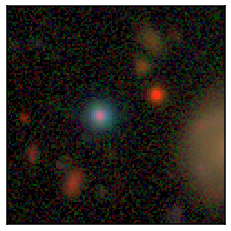

In [24]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.imshow(cutout_rgb, origin='upper')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [25]:
rax = 150.767393615929
decx = 2.7390523382661263
print(rax, decx)

filters = ['g','r','i']
ang_size_h = 10*u.arcsec
ang_size_w = 10*u.arcsec

coord = SkyCoord(rax, decx, frame='icrs', unit='deg')

s_ang = [ang_size_h, ang_size_w]
cutout_rgb, cutout_wcs = hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=False, 
    save_rgb=False, save_img=False, use_saved=False, archive=pdr2_wide)
print(cutout_rgb.data.shape)

150.767393615929 2.7390523382661263
(120, 120, 3)


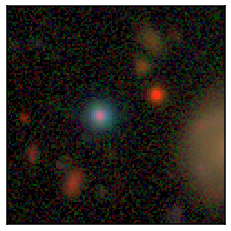

In [26]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.imshow(cutout_rgb, origin='upper')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [27]:
mean = np.mean(scores)
std = np.std(scores)
print(mean, mean+std, mean+2*std, mean+3*std)

1499.9718 1790.2245 2080.4771728515625 2370.7298583984375


In [28]:
idx_1sig = [idxs[i] for i in range(len(idxs)) if scores[i]>mean+1*std]
#print(idx_1sig)
print(len(idx_1sig))

502


In [ ]:
for idx in idx_1sig:
    idx = int(idx)
    obj = cat.loc[idx]
    objid = obj['object_id']
    
    imloc = idx2imloc[idx]
    resloc = idx2resloc[idx]
    im = imarr['images'][imloc]
    scoreint = int(scores[resloc])

    save_fn = f"../thumbnails/cosmos_targets/cosmos_1sig_fix/cosmos_idx{idx}_objectid{objid}_score{scoreint}.png"
    #ims = ims.transpose(3, 1, 2)
    im = luptonize(im)
    imwrite(save_fn, im)

In [ ]:
imdir = '/Users/ksf/code/kavli/cosmos_targets/cosmos_1sig_interesting/cosmos_bluecore'
idxs_blue = []
for fn in os.listdir(imdir):
    prestr = 'idx'
    idxstr = fn.split('_')[1][len(prestr):]
    idxs_blue.append(int(idxstr))
print(idxs_blue)

In [ ]:
np.set_printoptions(precision=15)

In [ ]:
rab, decb, objb = [], [], []
header = 'object_id, ra, dec, hsc_id'
ids_cat = []
for i in range(len(idxs_blue)):
    idxb = idxs_blue[i]

    row = cat.loc[idxb]
    objid = row['object_id']
    print(str(row['object_id']), idxb, row['ra_x'], row['dec_x'])
    objb.append(str(row['object_id']))
    rai = np.float64(row['ra_x']).astype(str)
    print(rai)
    rab.append(row['ra_x'])
    decb.append(row['dec_x'])
    
data_blue = np.array([objb, rab, decb, idxs_blue])
np.savetxt('../data/catalogs/cosmos_bluecore.csv', data_blue.T, delimiter=',', header=header, fmt='%s') #fmt=['%17s', '%.14f', '%.16f', '%d'])

In [ ]:
header_table =("| name   | ra           | dec          |\n"
               "| char   | double       | double       |")
ra1 = []
dec1 = []
for i in range(len(idx_1sig)):
    idx1 = idx_1sig[i]

    row = cat.loc[idx1]
    #objid = row['object_id']
    ra1.append(row['ra_x'])
    dec1.append(row['dec_x'])
    
idx_1sig_int = np.array(idx_1sig).astype(int)
data_1sig = np.array([idx_1sig_int, ra1, dec1])
np.savetxt('../data/catalogs/cosmos_1sig.dat', data_1sig.T, delimiter=' ', header=header_table, fmt=['%d', '%s','%s']) #fmt=['%17s', '%.14f', '%.16f', '%d'])

In [234]:
fits_dir = '/Users/ksf/code/kavli/cosmos_targets/cosmos_1sig_interesting/cosmos_bluecore_archive'
fits_files = glob.glob(fits_dir+'/*')
idx_archive = 2
im = []
filters = ['gp', 'rp', 'ip']
#filters = ['gp', 'rp', 'ip']
#filters = ['ip', 'rp', 'gp']
for filt in filters:
    print(filt)
    idxa = str(idx_archive).zfill(4)
    pattern = '{}.*COSMOS.{}.*.fits'.format(idxa, filt)
    for f in fits_files:
        match = re.search(pattern, f)
        if match:
            break
    if not match:
        raise ValueError('No file with that index and filter!')
    fits_fn = match.group(0)
    hdul = fits.open(f'{fits_dir}/{fits_fn}')
    
    im_layer = np.transpose(hdul[0].data)
    
    ncent = 5
    nside = im_layer.shape[0]
    imcut = im_layer[int(nside/2-ncent):int(nside/2+ncent), int(nside/2-ncent):int(nside/2+ncent)]
    print(imcut)
    
    im.append(im_layer)
    #print(max(np.array(im).flatten()), min(np.array(im).flatten()))
im = np.array(im).T


#im = np.arcsinh(im)

print(max(np.array(im).flatten()), min(np.array(im).flatten()))
imrgb = luptonize(im, rgb_stretch=10)
print(im.shape, imrgb.shape)

gp
[[ 22.319422  31.216276  40.722767  52.212994  62.150475  67.18834
   67.29097   61.82982   52.42734   42.98597 ]
 [ 27.878422  39.729343  53.586945  70.183495  84.958885  92.68286
   92.54115   83.51581   69.76036   55.78577 ]
 [ 33.23766   48.421024  67.46964   87.618706 107.02666  118.49888
  117.5932   105.669426  87.92137   67.93199 ]
 [ 37.91308   55.59885   77.14648  101.23553  123.63125  139.19511
  140.05882  125.52014  102.33039   77.64698 ]
 [ 39.71386   57.64804   80.035675 106.61532  130.57968  145.30356
  145.69664  130.37553  107.0294    79.83003 ]
 [ 38.265495  55.73192   78.712746 103.896576 125.34555  137.02953
  136.77975  123.767296 102.51577   77.367485]
 [ 35.51602   51.81609   70.52758   90.34369  108.636444 119.14907
  117.54668  106.93489   88.910065  68.41452 ]
 [ 32.224834  44.79942   58.849415  73.49924   85.13172   93.85115
   93.67801   85.59539   71.94405   55.63173 ]
 [ 26.83438   36.076244  46.928257  56.272217  64.6373    69.65983
   69.27338   64.8

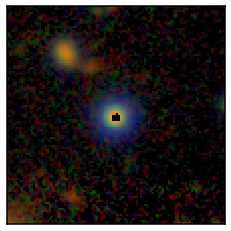

In [220]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.imshow(imrgb, origin='upper')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [230]:
ncent = 5
nside = imrgb.shape[0]
imcut = imrgb[int(nside/2-ncent):int(nside/2+ncent), int(nside/2-ncent):int(nside/2+ncent), :]
print(imcut.shape)

(10, 10, 3)


[[[ 55  97 103]
  [ 65 104 104]
  [ 69 110 107]
  [ 71 118 108]
  [ 76 123 103]
  [ 72 121 105]
  [ 70 116 106]
  [ 68 105 108]
  [ 76  76 112]
  [ 79  70 102]]

 [[ 64 112 106]
  [ 81 118 104]
  [ 95 126 101]
  [103 132  99]
  [103 139  97]
  [ 98 136  99]
  [ 91 129 104]
  [ 85 120 106]
  [ 90  88 111]
  [ 87  81 104]]

 [[ 89 117 101]
  [115 126  93]
  [127 139  90]
  [148 142  83]
  [150 149  80]
  [138 151  84]
  [121 145  92]
  [106 135  98]
  [ 93 122 102]
  [ 86 114  98]]

 [[ 93 132 102]
  [143 136  85]
  [171 145  75]
  [205 143  64]
  [205 152  62]
  [192 153  67]
  [164 152  75]
  [127 148  89]
  [105 134  97]
  [ 91 119  99]]

 [[110 137  97]
  [156 149  79]
  [221 142  60]
  [255 122  43]
  [255 124  39]
  [  0   0   0]
  [200 155  64]
  [152 156  78]
  [121 136  93]
  [ 95 120 103]]

 [[121 140  93]
  [169 153  74]
  [240 146  53]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [171 155  72]
  [129 140  90]
  [ 94 124 104]]

 [[123 138  93]
  [167 156  

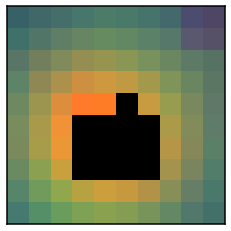

In [231]:
print(imcut)
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.imshow(imcut, origin='upper')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [207]:
fits_dir = '/Users/ksf/code/kavli/anomalies-GAN-HSC/webpage/fits_images/cosmos_bluecore'
fits_files = glob.glob(fits_dir+'/*')
idx_archive = 2
im = []
filters = ['I']
#filters = ['B', 'rp', 'ip']
#filters = ['gp', 'rp', 'ip']
#filters = ['ip', 'rp', 'gp']
for filt in filters:
    print(filt)
    idxa = str(idx_archive).zfill(4)
    pattern = '{}.*acs_{}.*.fits'.format(idxa, filt)
    for f in fits_files:
        match = re.search(pattern, f)
        if match:
            break
    if not match:
        raise ValueError('No file with that index and filter!')
    fits_fn = match.group(0)
    hdul = fits.open(f'{fits_dir}/{fits_fn}')
    im.append(hdul[0].data)
print(max(np.array(im).flatten()), min(np.array(im).flatten()))


print(high)
print(max(np.array(im).flatten()), min(np.array(im).flatten()))
im = np.array(im).T
im = np.arcsinh(im)

immean = np.mean(np.array(im))
imstd = np.std(np.array(im))
high = immean + 3*imstd
im = np.clip(im, None, high)

im = (im - np.min(im))/np.ptp(im)
print(max(np.array(im).flatten()), min(np.array(im).flatten()))

I
9.196823120117188 -0.014176859520375729
0.112729121818746
9.196823120117188 -0.014176859520375729
1.0 0.0


(534, 534, 1)
(534, 534)


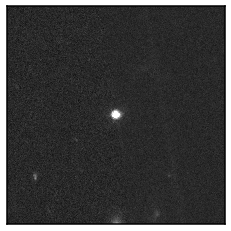

In [208]:
plt.figure(figsize=(4,4))
ax = plt.gca()
print(im.shape)
im0 = im[:,:,0]
print(im0.shape)
ax.imshow(im0, origin='upper', cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
plt.show()